In [ ]:
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
import os
import re
import cv2
import glob
import dlib
import random
import numpy as np
import pandas as pd
from ipywidgets import IntProgress
from IPython.display import display

from google.colab.patches import cv2_imshow #this will make viewing images in Colab notebook possible since 'cv2.imshow()' is not supported in Colab notebooks.

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('seaborn')
%matplotlib inline 

%cd /content/drive/My Drive/IYTE/CENG 507 (Introduction to Biometric Recognition)/Project

/content/drive/My Drive/IYTE/CENG 507 (Introduction to Biometric Recognition)/Project


In [ ]:
model_file = "./model/resnet/res10_300x300_ssd_iter_140000_fp16.caffemodel"
config_file = "./model/resnet/deploy.prototxt"
model = cv2.dnn.readNetFromCaffe(config_file, model_file)

landmark_detector = dlib.shape_predictor("./model/dlib_landmark/shape_predictor_68_face_landmarks.dat")

In [ ]:
data = pd.DataFrame([os.path.basename(file) for file in glob.glob("./data/full_faces/non_occluded/images/*.jpg")], columns=["file"])

data = data.sort_values(by="file", ignore_index=True)
data["identity"] = data["file"].apply(lambda x: re.sub("[0-9]","",x[:-4]) if re.match('[a-z]', x[:-4]) else x[:-4])
data["image_no"] = data["file"].apply(lambda x: re.sub("_|[a-z]","",x[:-4]) if re.match('[a-z]', x[:-4]) else "01")
data["image_count"] = data["identity"].apply(lambda x: data[data.identity == x].shape[0])

#numerification of the identities
id_dict = { name: i for i, name in enumerate(data["identity"].unique())}
data["identity"] = data["identity"].apply(lambda x: id_dict[x])

data["partition"] = ""
alter = 0
alter2 = 0
for i in range(len(data["identity"].unique())): #for every identity
  if list(data.loc[data.identity == i, "image_count"])[0] == 1:#if image count is 1, goes test or validation alternating
    data.loc[data.identity == i, "partition"] = "validation" if alter % 2 == 0 else "test"
    alter +=1
  else:
    data.loc[(data.identity == i) & (data.image_no == "01"), "partition"] = "gallery"
    data.loc[(data.identity == i) & (data.image_no != "01"), "partition"] = "test" if alter2 % 2 == 0 else "validation"
    alter2 += 1
    
#marking unkown images' identity as -1
for i, row in data.iterrows():
  if data[data.identity == row.identity].shape[0] == 1:
    data.loc[i, "identity"] = -1

data[["file", "identity", "partition"]].to_csv("./data/full_faces/data_map_face_parts.csv", index=None)

In [ ]:
data = pd.read_csv("./data/full_faces/data_map_face_parts.csv")

#Non-Occluded Partial Face Recognition

In [ ]:
def get_face(img):
  (h, w) = img.shape[:2] #gets the height and width of the image
  resized_img = cv2.resize(img, (300, 300)) #We will resize the image to 300x300 since its our models defined input size.
  blob = cv2.dnn.blobFromImage(resized_img, 1.0, (300, 300), (104, 117, 123), swapRB=False) #We don't use scaling so the scale factor is 1.0. (104, 117, 123) are the defined mean pixel values for our model.
  model.setInput(blob) #We set the blobs (attention regions) as input
  detections = model.forward() #and let the model make detections. It will create multiple detections but we only need one.
  for detection in detections[0][0][:5]: #For the first 5 detections, we will turn it into a box. If there is not suitable area in first 5 detections, we assume no face has been detected.
    box = detection[3:7] * np.array([w, h, w, h])
    (startX, startY, endX, endY) = box.astype("int")
    if(startX < w and startY < h and endX < w and endY < h): #if detected region is fully inside the image
        return cv2.cvtColor(img[startY:endY, startX:endX], cv2.COLOR_BGR2GRAY), dlib.rectangle(startX, startY, endX, endY) 
#we return the first suitable coordinates as an image(grayscaled) and a dlib rectangle since we assume the image has only one face in it.

In [ ]:
def cut_face_parts(img):
  (h, w) = img.shape[:2] #gets the height and width of the image
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #Dlib lanmark detector uses single channeled input so we turn the image into grayscale.
  _, rect = get_face(img) #returns the face and the bounding rectangle of face. We are only using rectangle for this part
  landmarks = landmark_detector(gray, rect) #dlib's landmark detector
  points = landmarks.parts() #'points' is an array of 68 tuples being the coordinates of detections.
  scale = 0.05 #We enlarge the rectangles by .05 of the width and height in order to have a more wide and general facial part image.
               #This will provide better feature extraction while performing recognition.
  
  #obtain the corresponding points for the facial area and turn the image into grayscale
  nose = cv2.cvtColor(img[int(points[39].y) : int(points[33].y), int(points[39].x) : int(points[42].x)], cv2.COLOR_BGR2GRAY)
  left_eye = cv2.cvtColor(img[int(points[43].y - scale*h) : int(points[46].y + scale*h), int(points[42].x - scale*w) : int(points[45].x + scale*w)], cv2.COLOR_BGR2GRAY)
  right_eye = cv2.cvtColor(img[int(points[37].y - scale*h) : int(points[40].y + scale*h), int(points[36].x - scale*w) : int(points[39].x + scale*w)], cv2.COLOR_BGR2GRAY)
  mouth = cv2.cvtColor(img[int(points[48].y - scale*h) : int(points[57].y + scale*h), int(points[48].x - scale*w) : int(points[54].x + scale*w)], cv2.COLOR_BGR2GRAY)

  return [("nose", nose), ("lefteye", left_eye), ("righteye", right_eye), ("mouth", mouth)]

In [ ]:
def cut_face_parts2(path='/content/drive/My Drive/Development/Projects/face_part_detection', accuracy_threshold=0.2, labels=None, loadOrSave=1):
  from detecto.core import Model, Dataset 

  if labels is None:
        labels = ['eye', 'nose', 'mouth']
  
  
  if(loadOrSave == 1): # training model
    dataset = Dataset(dataset_path+'data/train')  # Loading images and label data
    model = Model(labels)  # setting labels for model
    model.fit(dataset) # training
    model.save(path + "/face_part_detection_model.pth") # saving model

  elif(loadOrSave == 0):# loading saved model
    model = Model(labels)  # To predict eye, nose and mouth
    model.load(path+ "face_part_detection_model.pth", labels)
  
  images = glob.glob(path + '/data/test/*.jpg')

  for img in images: # for each image making predictions which includes labels, detection bounding boxes and accuricy scores for each detection
    
    #read image
    im = cv2.imread(img)

    # show file name
    print(im.filename.split("/")[-1])

    # make prediction
    result = model.predict(im)

    labels = result[0]
    points = result[1].numpy()
    accs = result[2].numpy()

    l=len(result[0])

    correctNose = [0,[]]
    correctMouth = [0,[]]
    correctEye1 = [0,[]]
    correctEye2 = [0,[]]

    # there are multiple detections in each image. We get first nose, mouth and first two eyes with highest scores.
    # And accuricy threshold is 0.2 in this case.
    for i in range(l):
        if labels[i]=="nose":
          if accs[i] > correctNose[0] and accs[i] > accuracy_threshold :
            correctNose[0] = accs[i]
            correctNose[1] = points[i]
        elif labels[i]=="mouth" and accs[i] > accuracy_threshold :
          if accs[i] > correctMouth[0]:
            correctMouth[0] = accs[i]
            correctMouth[1] = points[i]
        elif labels[i]=="eye" :
          if accs[i] > correctEye1[0] and accs[i] > accuracy_threshold :
            correctEye1[0] = accs[i]
            correctEye1[1] = points[i]
          elif accs[i] > correctEye2[0] and accs[i] > accuracy_threshold :
              correctEye2[0] = accs[i]
              correctEye2[1] = points[i]

        # if parts exists, crop and save the part
        if len(correctEye1[1]) > 0:
          eye1 = im.crop((correctEye1[1][0], correctEye1[1][1], correctEye1[1][2],correctEye1[1][3]))
          # cv2.imwrite.save("/content/drive/My Drive/Development/Projects/face_part_detection/results/cropped/eye1_"+str(im.filename.split("/")[-1]), eye1)
        if len(correctEye2[1]) > 0:
          eye2 = im.crop((correctEye2[1][0], correctEye2[1][1], correctEye2[1][2],correctEye2[1][3]))
          # cv2.imwrite.save("/content/drive/My Drive/Development/Projects/face_part_detection/results/cropped/eye2_"+str(im.filename.split("/")[-1]), eye2)
        if len(correctNose[1]) > 0:
          nose = im.crop((correctNose[1][0], correctNose[1][1], correctNose[1][2],correctNose[1][3]))
          # cv2.imwrite("/content/drive/My Drive/Development/Projects/face_part_detection/results/cropped/nose_"+str(im.filename.split("/")[-1]), nose)
        if len(correctMouth[1]) > 0:
          mouth = im.crop((correctMouth[1][0], correctMouth[1][1], correctMouth[1][2],correctMouth[1][3]))
          # cv2.imwrite("/content/drive/My Drive/Development/Projects/face_part_detection/results/cropped/mouth_"+str(im.filename.split("/")[-1]), mouth)
      
  # obtain the corresponding points for the facial area and turn the image into grayscale
  nose = cv2.cvtColor(nose, cv2.COLOR_BGR2GRAY)
  eye1 = cv2.cvtColor(eye1, cv2.COLOR_BGR2GRAY)
  eye2 = cv2.cvtColor(eye2, cv2.COLOR_BGR2GRAY)
  mouth = cv2.cvtColor(mouth, cv2.COLOR_BGR2GRAY)

  return [("nose", nose), ("lefteye", eye1), ("righteye", eye2), ("mouth", mouth)]

In [ ]:
def get_face_parts(data, partition):
  i = 0
  df = pd.DataFrame(columns=["identity","part_label","img"])
  for _, row in data[data.partition == partition].iterrows():
    parts = cut_face_parts(cv2.imread("./data/full_faces/non_occluded/images/"+row.file))
    for p, (label, part) in enumerate(parts):
      if p == 1 or p == 2:
        df.loc[i] = [row.identity, label, part]
        i += 1  
  return [df.img, df.identity, df.part_label]

In [ ]:
gallery_images, gallery_labels, gallery_part_names = get_face_parts(data, "gallery")

val_images, val_labels, val_part_names = get_face_parts(data, "validation")

test_images, test_labels, test_part_names = get_face_parts(data, "test")

In [ ]:
def eval(images, labels, part_names, radius, neighbors, grid_x, grid_y, threshold):
  recognizer = cv2.face.LBPHFaceRecognizer_create(radius = radius, neighbors = neighbors, grid_x= grid_x, grid_y = grid_y)
  recognizer.train(gallery_images, np.array(list(gallery_labels)))
  parts_result = pd.DataFrame(columns=["correct_label", "prediction", "sub_prediction", "distance", "part_name" , "error"])
  try:
    for i, img in enumerate(images):
      prediction , distance = recognizer.predict(img)

      correct_label = labels[i]

      sub_prediction = prediction
      prediction = prediction if distance <  threshold else -1

      error = 0 if prediction == correct_label else 1

      parts_result.loc[i] = [correct_label,  prediction, sub_prediction, distance, part_names[i], error]

    result = pd.DataFrame(columns=["correct_label", "prediction", "sub_prediction", "distance", "part_name" , "error"])
    k = 0
    for i in range(0,parts_result.shape[0], 4):
      result.loc[k] = parts_result.loc[parts_result[i:i+4].distance.idxmin()]
      k += 1

    FAR = round(result[(result.correct_label == -1) & (result.error == 1)].shape[0] / result[result.correct_label == -1].shape[0], 2)
    FRR = round(result[(result.correct_label != -1) & (result.error == 1)].shape[0] / result[result.correct_label != -1].shape[0], 2)
    OE  = round(result[result.error == 1].shape[0] / result.shape[0], 2)
  except Exception as e :
    print("Error With:", radius, neighbors, grid_x, grid_y )
    print(e)
    return 1,1,1

  return FAR, FRR, OE
  #return result

In [ ]:
def random_search(images, labels, part_names, count):
  search_result = pd.DataFrame(columns=["params","FAR","FRR","OE"])
  bar = IntProgress(min=0, max=count)
  display(bar)
  for i in range(0,count):
    radius = random.randint(1,9)
    neighbors = random.randint(1,9)
    grid_x = random.randint(1,9)
    grid_y = random.randint(1,9)
    treshold = 10 *random.randint(1,10)
    FAR, FRR, OE = eval(images, labels, part_names, radius, neighbors, grid_x, grid_y, treshold)
    search_result.loc[i] = ["r:{}, n:{}, x:{}, y:{}, t:{}".format(radius, neighbors, grid_x, grid_y, treshold), FAR, FRR, OE]
    bar.value += 1
  return search_result

In [ ]:
def threshold_search(images, labels, part_names, values, params):
  result = pd.DataFrame(columns=["value","FAR","FRR","OE"])
  bar = IntProgress(min=0, max=len(values))
  display(bar)
  for i, t in enumerate(values):
    FAR, FRR, OE = eval(images, labels, part_names, params[0], params[1], params[2], params[3], t)
    result.loc[i] = [t, FAR, FRR, OE]
    bar.value += 1
  return result

IntProgress(value=0, max=50)

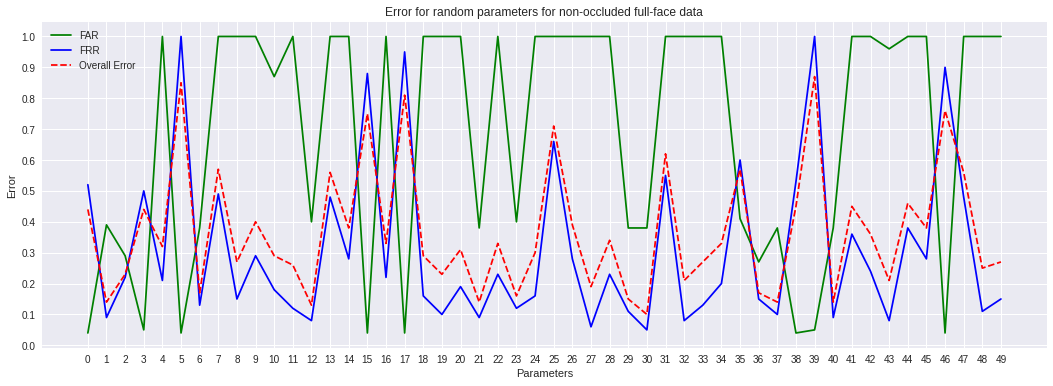

In [ ]:
#random search
count = 50
result = random_search(val_images, val_labels, val_part_names, count)
plt.xlabel("Parameters")
plt.ylabel("Error")
plt.title("Error for random parameters for non-occluded full-face data")
plt.xticks(range(0,count))
plt.yticks(np.arange(0,1.1,0.1))
plt.rcParams['figure.figsize'] = (18,6)
plt.plot(range(0,count), result.FAR, color='green', label='FAR')
plt.plot(range(0,count), result.FRR, color='blue', label='FRR')
plt.plot(range(0,count), result.OE, color='red', linestyle='--', label='Overall Error')
plt.legend()
plt.savefig('./results/Random Search for Non-Occluded Partial-Face Data updated.png')

In [ ]:
result.loc[36]

params    r:5, n:5, x:5, y:9, t:60
FAR                           0.27
FRR                           0.15
OE                            0.17
Name: 36, dtype: object

In [ ]:
result.loc[1]

params    r:6, n:9, x:3, y:6, t:50
FAR                           0.39
FRR                           0.09
OE                            0.14
Name: 1, dtype: object

IntProgress(value=0, max=30)

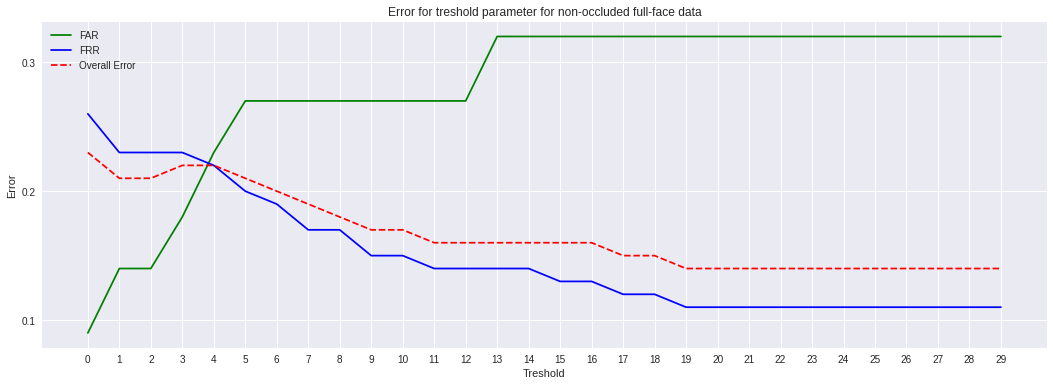

In [ ]:
#threshold search
r = range(50,80)
t_result = threshold_search(val_images, val_labels, val_part_names, r, [5,5,5,9])
plt.xlabel("Treshold")
plt.ylabel("Error")
plt.title("Error for treshold parameter for non-occluded full-face data")
plt.xticks(range(0, len(r)))
plt.yticks(np.arange(0,1.1,0.1))
plt.rcParams['figure.figsize'] = (18,6)
plt.plot(range(0, len(r)), t_result.FAR, color='green', label='FAR')
plt.plot(range(0, len(r)), t_result.FRR, color='blue', label='FRR')
plt.plot(range(0, len(r)), t_result.OE, color='red', linestyle='--', label='Overall Error')
plt.legend()
plt.savefig('./results/Threshold Search for Occluded Full-Face Data params 5 5 5 9.png')

In [ ]:
#Crossover Error Rate
t_result.loc[4]

value    54.00
FAR       0.23
FRR       0.22
OE        0.22
Name: 4, dtype: float64

In [ ]:
#optional result
t_result.loc[21]

value    71.00
FAR       0.32
FRR       0.11
OE        0.14
Name: 21, dtype: float64

In [ ]:
FAR, FRR, OE = eval(test_images, test_labels, test_part_names, 5, 5, 5, 9, 71)
print("FAR: {}, FRR: {}, OE: {}".format(FAR, FRR, OE))

FAR: 0.29, FRR: 0.15, OE: 0.17


#Occluded Partial Face Identification

In [ ]:
def get_occ_face_parts(data, partition, occ_type):
  i = 0
  df = pd.DataFrame(columns=["identity","part_label","img"])
  for _, row in data[data.partition == partition].iterrows():
    parts = cut_face_parts(cv2.imread("./data/full_faces/non_occluded/images/"+row.file))
    if occ_type == "mask":
      for p, (label, part) in enumerate(parts):
        if p == 1 or p == 2:
          df.loc[i] = [row.identity, label, part]
          i += 1
        else:
          df.loc[i] = [row.identity, label, np.full(part.shape, 128)]
          i += 1

    elif occ_type == "eyeglasses":
      for p, (label, part) in enumerate(parts):
        if p == 0 or p == 3:
          df.loc[i] = [row.identity, label, part]
          i += 1
        else:
          df.loc[i] = [row.identity, label, np.full(part.shape, 128)]
          i += 1     

  return [df.img, df.identity, df.part_label]

In [ ]:
def occ_eval(images, labels, part_names, radius, neighbors, grid_x, grid_y, threshold):
  recognizer = cv2.face.LBPHFaceRecognizer_create(radius = radius, neighbors = neighbors, grid_x= grid_x, grid_y = grid_y)
  recognizer.train(gallery_images, np.array(list(gallery_labels)))
  parts_result = pd.DataFrame(columns=["correct_label", "prediction", "sub_prediction", "distance", "part_name" , "error"])
  try:
    for i, img in enumerate(images):
      prediction , distance = recognizer.predict(img)

      correct_label = labels[i]

      sub_prediction = prediction
      prediction = prediction if distance <  threshold else -1

      error = 0 if prediction == correct_label else 1

      parts_result.loc[i] = [correct_label,  prediction, sub_prediction, distance, part_names[i], error]
    
    result = pd.DataFrame(columns=["correct_label", "prediction", "sub_prediction", "distance", "part_name" , "error"])
    k = 0
    for i in range(0,parts_result.shape[0], 4):
      result.loc[k] = parts_result.loc[parts_result[i:i+4].distance.idxmin()]
      k += 1

    FAR = round(result[(result.correct_label == -1) & (result.error == 1)].shape[0] / result[result.correct_label == -1].shape[0], 2)
    FRR = round(result[(result.correct_label != -1) & (result.error == 1)].shape[0] / result[result.correct_label != -1].shape[0], 2)
    OE  = round(result[result.error == 1].shape[0] / result.shape[0], 2)
  except Exception as e :
    print("Error With:", radius, neighbors, grid_x, grid_y )
    print(e)
    return 1,1,1

  return FAR, FRR, OE
  #return result

## Mask

In [ ]:
occ_test_images, occ_test_labels, occ_test_part_names = get_occ_face_parts(data, "test", "mask")

FAR, FRR, OE = occ_eval(occ_test_images, occ_test_labels, occ_test_part_names, 5, 5, 5, 9, 71)
print("FAR: {}, FRR: {}, OE: {}".format(FAR, FRR, OE))

FAR: 0.33, FRR: 0.27, OE: 0.28


##Eyeglasses

In [ ]:
occ_test_images, occ_test_labels, occ_test_part_names = get_occ_face_parts(data, "test", "eyeglasses")

FAR, FRR, OE = occ_eval(occ_test_images, occ_test_labels, occ_test_part_names, 5, 5, 5, 9, 71)
print("FAR: {}, FRR: {}, OE: {}".format(FAR, FRR, OE))

FAR: 0.02, FRR: 1.0, OE: 0.87


## Experiments

Semi Visible Glasses

In [ ]:
def set_opacity(img,a):
  (h, w) = img.shape[:2]
  r = img.copy()
  cv2.rectangle(r, (0, h), (w, 0), (128,128,128), -1  ) 
  return cv2.addWeighted(r, a, img, 1 - a, 0)

In [ ]:
def semi_visible_eyeglasses(data, partition, alp):
  i = 0
  df = pd.DataFrame(columns=["identity","part_label","img"])
  for _, row in data[data.partition == partition].iterrows():
    parts = cut_face_parts(cv2.imread("./data/full_faces/non_occluded/images/"+row.file))

    for p, (label, part) in enumerate(parts):
      if p == 0 or p == 3:
        df.loc[i] = [row.identity, label, part]
        i += 1
      else:
        df.loc[i] = [row.identity, label, set_opacity(part, alp)]
        i += 1     

  return [df.img, df.identity, df.part_label]

In [ ]:
semi_visible_report = pd.DataFrame(columns=["Error","alpla"])
i = 0
for a in range(100,105,5):
  occ_test_images, occ_test_labels, occ_test_part_names = semi_visible_eyeglasses(data, "test", a/100)
  _, _, OE = occ_eval(occ_test_images, occ_test_labels, occ_test_part_names, 5, 5, 5, 9, 71)
  semi_visible_report.loc[i] = [OE, a/100]
  print(i)
  i += 1

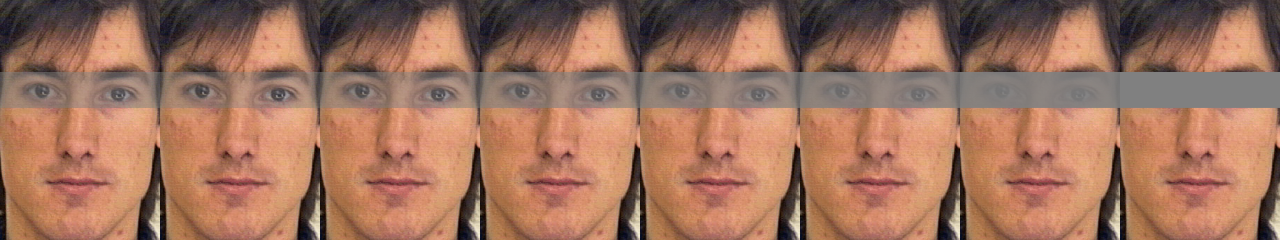

In [ ]:
img = create_occlusion(cv2.imread("./data/full_faces/non_occluded/images/adrian01.jpg"), 0.5)
for a in np.arange(0.6, -0.1, -0.1):
  img1 = create_occlusion(cv2.imread("./data/full_faces/non_occluded/images/adrian01.jpg"), a)
  img = np.concatenate((img, img1), axis=1)
cv2_imshow(img)

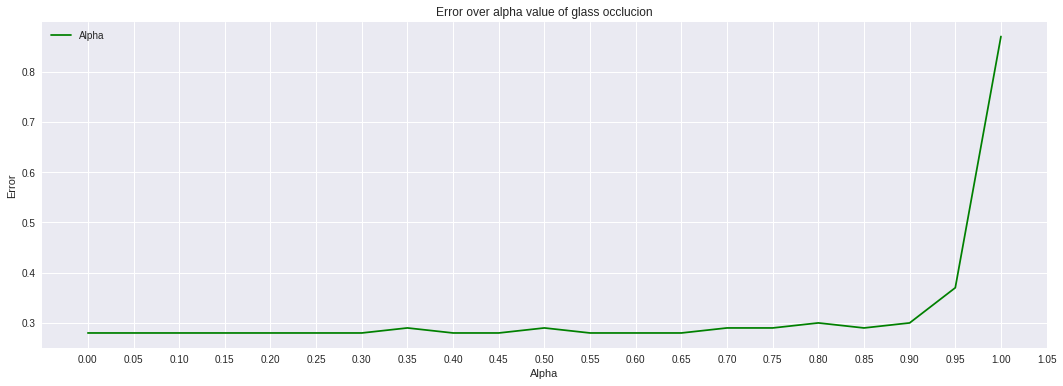

In [ ]:
plt.xlabel("Alpha")
plt.ylabel("Error")
plt.title("Error over alpha value of glass occlucion")
plt.xticks(np.arange(0,1.1,0.05))
#plt.yticks(np.arange(0,1.1,0.05))
plt.rcParams['figure.figsize'] = (18,6)
plt.plot(semi_visible_report.alpla, semi_visible_report.Error, color='green', label='Alpha')
plt.legend()
plt.savefig('./results/Error over alpha value of glass occlucion.png')

In [ ]:
def create_occlusion(img, a):
  (h, w) = img.shape[:2]
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  face, rect = get_face(img)
  landmarks = landmark_detector(face, rect)
  points = landmarks.parts()
  eyeglasses = img.copy()

  #scale the rectangle around landmarks so it will occlude desired parts
  cv2.rectangle(img[rect.top():rect.bottom(), rect.left():rect.right()], (0, int(points[37].y - 0.05*h)-80), (w, int(points[46].y + 0.055*h)-80), (128,128,128), -1  ) 
  
  img = cv2.addWeighted(eyeglasses[rect.top():rect.bottom(), rect.left():rect.right()], a, img[rect.top():rect.bottom(), rect.left():rect.right()], 1 - a, 0)
  return cv2.resize(img, (0,0), fx=0.7, fy=0.7) 

In [ ]:
import time
time.sleep(60  * 60)

(0.0, 1.0, 0.21)

## Mask Size Experiment


In [2]:
def mask_size(data, partition, mask_size):
  i=0
  df = pd.DataFrame(columns=["identity","part_label","img"])
  for _, row in data[data.partition == partition].iterrows():
      im = cv2.imread("detection_and_occlusion/data/"+row["file"].split(".")[0]+"_"+str(mask_size)+".jpg")
      if im is not None:
        #print(row["file"])
        parts = cut_face_parts(im)

        for p, (label, part) in enumerate(parts):
            df.loc[i] = [row.identity, label, part]
            i += 1
  return [df.img, df.identity, df.part_label]

In [3]:
mask_size_report = pd.DataFrame(columns=["Error","alpha"])
i = 0
for a in range(0,20,1):
  occ_test_images, occ_test_labels, occ_test_part_names = mask_size(data, "test",a)
  _, _, OE = occ_eval(occ_test_images, occ_test_labels, occ_test_part_names, 7, 7, 7, 11, 71)
  print(OE)
  print("----"+str(a))
  mask_size_report.loc[i] = [OE, a]
  print(i)
  i += 1

NameError: ignored

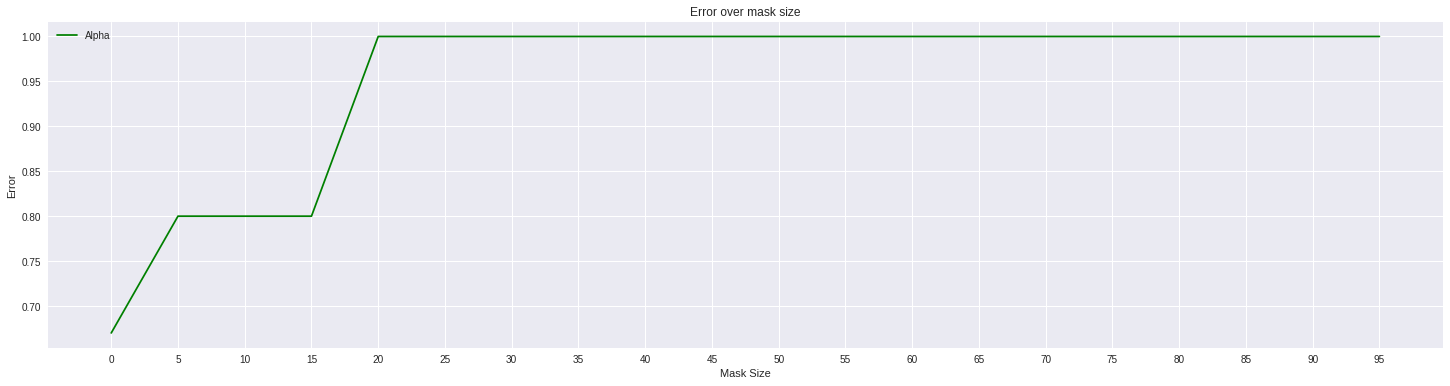

In [ ]:
plt.xlabel("Mask Size")
plt.ylabel("Error")
plt.title("Error over mask size")
plt.xticks(np.arange(0,100,5))
#plt.yticks(np.arange(0,1.1,0.05))
plt.rcParams['figure.figsize'] = (25,6)
plt.plot(mask_size_report.alpha, mask_size_report.Error, color='green', label='Alpha')
plt.legend()
plt.savefig('./results/Error over mask size.png')